## test

In [1]:
import numpy as np
try:
    from matplotrender.src.matplotrender import *
except:
    #!pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
    
from utils.ict_face_model import ICT_face_model
from utils.util import *

# import meshplot as mp

In [2]:
src_mesh = EasyDict()

src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)


	 src vertices: (11248, 3) 	 faces: (22288, 3)


In [3]:
src_mesh.f 

array([[  873,    11,   870],
       [  870,    11,  1492],
       [   17,  1189,  1190],
       ...,
       [11154, 11039, 11040],
       [11155, 11043, 11039],
       [11156,  9679, 11043]])

In [ ]:
# print(src_mesh.v.min(0), src_mesh.v.max(0))


# large cube
control_mesh = EasyDict()
# quad mesh
control_mesh.f = np.array([
    [0,2,3,1],
    [0,1,5,4],
    [1,3,7,5],
    [3,2,6,7],
    [2,0,4,6],
    [5,7,6,4],
])
# make triangle great again 
control_mesh.f = control_mesh.f[:,[[3,2,1],[3,1,0]]].reshape(-1, 3)

control_mesh.v = np.zeros((8,3))

## X, Y, Z
control_mesh.v[0] = src_mesh.v.max(0)
control_mesh.v[1,0], control_mesh.v[1,1], control_mesh.v[1,2] = src_mesh.v.max(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[2,0], control_mesh.v[2,1], control_mesh.v[2,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[3,0], control_mesh.v[3,1], control_mesh.v[3,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]

control_mesh.v[4,0], control_mesh.v[4,1], control_mesh.v[4,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[5,0], control_mesh.v[5,1], control_mesh.v[5,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[6,0], control_mesh.v[6,1], control_mesh.v[6,2] = src_mesh.v.min(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[7] = src_mesh.v.min(0)

# control_mesh.v[:,1]=control_mesh.v[:,1]*1.05
control_mesh.v=control_mesh.v*1.1


control_mesh_v2 = control_mesh.v.copy()
control_mesh_v2[0:4, 0] = control_mesh_v2[0:4, 0]+0.8


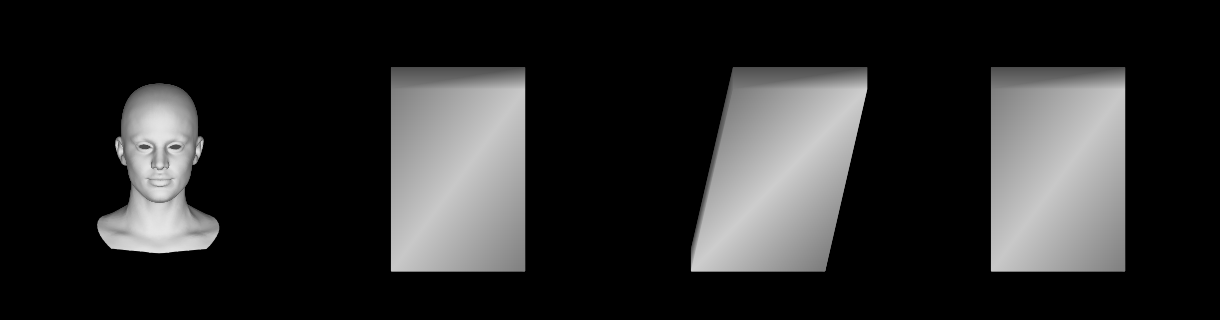

In [5]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

v_list=[ src_mesh.v, control_mesh.v, control_mesh_v2, np.r_[src_mesh.v, control_mesh.v]]
f_list=[ src_mesh.f, control_mesh.f, control_mesh.f, np.r_[src_mesh.f, control_mesh.f+src_mesh.f.max()+1]]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

## Mean Value Coordinate function

In [15]:
def MVC(src_mesh, control_mesh, _func_=None, eps=1e-8):
    """_summary_

    Args:
        src_mesh (easydict): simple dict for source mesh attributes
        control_mesh (easydict): simple dict for control mesh attributes
        _func_ (np.ndarry, optional): function on control mesh vertex to interpolate. Defaults to None.
        eps (float, optional): threshold. Defaults to 1e-8.

    Returns:
        np.ndarry: new vertices for source mesh
    """
    
    if _func_ is None:
        _func_ = control_mesh.v

    # new_v = np.zeros_like(src_mesh.v)
    
    new_F = np.zeros_like(src_mesh.v)
    new_W = np.zeros(src_mesh.v.shape[0])
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
            
            # if dj[jdx] < eps:
            #     new_v[vdx] = _func_[jdx]
                
            Uj[jdx] = Pj_v / dj[jdx]
        
        # Wj = np.zeros_like((control_mesh.v))
        for tri_idx in control_mesh.f:
            
            f0, f1, f2 = _func_[tri_idx]
            i0, i1, i2 = tri_idx
            
            # print(i0, i1, i2)
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                determinant = np.linalg.det(Uj[tri_idx])
                sign = -1 if determinant < 0 else 1
                
                s0 = sign * np.sqrt(1-c0**2)
                s1 = sign * np.sqrt(1-c1**2)
                s2 = sign * np.sqrt(1-c2**2)
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
    return new_F / new_W[..., None]


def MVC_weight(src_mesh, control_mesh, eps=1e-8):
    """_summary_

    Args:
        src_mesh (easydict): simple dict for source mesh attributes
        control_mesh (easydict): simple dict for control mesh attributes
        eps (float, optional): threshold. Defaults to 1e-8.

    Returns:
        np.ndarry: weight to control mesh vertices for each source vertex
    """
    
    new_W = np.zeros((src_mesh.v.shape[0], control_mesh.f.shape[0], 3))
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
                            
            Uj[jdx] = Pj_v / dj[jdx]
        
        # Wj = np.zeros_like((control_mesh.v))
        for tdx, tri_idx in enumerate(control_mesh.f):
            
            i0, i1, i2 = tri_idx
            
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_W[vdx][tdx][0] = W0
                new_W[vdx][tdx][1] = W1
                new_W[vdx][tdx][2] = W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                # determinant = np.linalg.det(Uj[tri_idx])
                # sign = -1 if determinant < 0 else 1
                
                # s0 = sign * np.sqrt(1-c0**2)
                # s1 = sign * np.sqrt(1-c1**2)
                # s2 = sign * np.sqrt(1-c2**2)
                s0 = np.abs(np.sqrt(1-c0**2))
                s1 = np.abs(np.sqrt(1-c1**2))
                s2 = np.abs(np.sqrt(1-c2**2))
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_W[vdx][tdx][0] = W0
                new_W[vdx][tdx][1] = W1
                new_W[vdx][tdx][2] = W2
    return new_W

def apply_MVC_weight(new_W, control_mesh, _func_=None):
    new_V = np.zeros((src_mesh.v.shape[0], 3))
    new_VW = np.zeros((src_mesh.v.shape[0]))
    
    for vdx in range(new_W.shape[0]):
        for tdx, tri_idx in enumerate(control_mesh.f):
            
            f0, f1, f2 = _func_[tri_idx]
            
            new_V[vdx] += (new_W[vdx][tdx][0] * f0) + (new_W[vdx][tdx][1] * f1) + (new_W[vdx][tdx][2] * f2)
            new_VW[vdx] += new_W[vdx][tdx].sum(0)
            
    new_V = new_V / new_VW[...,None]
    return new_V

# Run

### all in one

In [16]:
new_v = MVC(src_mesh, control_mesh, control_mesh_v2)

### save weight and apply later

In [11]:
new_w = MVC_weight(src_mesh, control_mesh, control_mesh_v2)
new_w.shape


(11248, 12, 3)

In [13]:
new_v2 = apply_MVC_weight(new_w, control_mesh, control_mesh_v2)

In [8]:
print(src_mesh.v.min(0), src_mesh.v.max(0))
print(new_v.min(0), new_v.max(0))

[-1.18697512 -1.81234658 -1.37132633] [1.12008107 1.3834517  0.78344184]
[-1.05129244 -1.81234658 -1.37132633] [1.33846999 1.3834517  0.78344184]


## Visualize

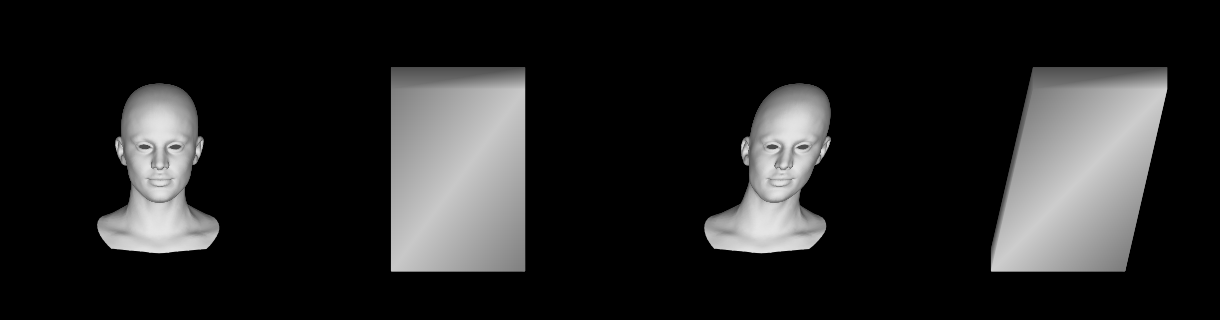

In [33]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        new_v2, 
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:

from scipy.spatial import SphericalVoronoi

def project_to_unit_sphere(v0, cage_vertices):
    directions = cage_vertices - v0[None, :]
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    sphere_points = directions / norms
    return sphere_points, directions, norms


def compute_spherical_voronoi_area(sphere_points):
    sv = SphericalVoronoi(sphere_points, radius=1.0, center=np.array([0., 0., 0.]))
    sv.sort_vertices_of_regions()

    def area_of_polygon(verts):
        # 각 spherical triangle의 면적 계산 (Girard's theorem 사용)
        def angle(a, b):
            return np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))

        total_area = 0.0
        for i in range(1, len(verts) - 1):
            a = verts[0]
            b = verts[i]
            c = verts[i + 1]
            alpha = angle(b, c)
            beta = angle(c, a)
            gamma = angle(a, b)
            # spherical excess
            excess = alpha + beta + gamma - np.pi
            total_area += excess
        return total_area

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = area_of_polygon(verts)
        areas.append(area)
    return np.array(areas)

def interpolate_using_weights(v0, cage_vertices, cage_function):
    sphere_points, directions, norms = project_to_unit_sphere(v0, cage_vertices)
    weights = compute_spherical_voronoi_area(sphere_points)
    weights /= np.sum(weights)  # normalize

    output = np.sum(weights[:, None] * cage_function, axis=0)
    return output

def cage_based_interpolation(target_vertices, cage_vertices, cage_function):
    outputs = []
    for v0 in target_vertices:
        out = interpolate_using_weights(v0, cage_vertices, cage_function)
        outputs.append(out)
    return np.array(outputs)


#############


import numpy as np
from scipy.spatial import SphericalVoronoi

def project_to_unit_sphere(v0, cage_vertices):
    directions = cage_vertices - v0[None, :]
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    sphere_points = directions / norms
    return sphere_points, directions, norms.squeeze()

def compute_spherical_voronoi_area(sphere_points):
    sv = SphericalVoronoi(sphere_points, radius=1.0, center=np.array([0., 0., 0.]))
    sv.sort_vertices_of_regions()

    def angle(u, v):
        return np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))

    def spherical_polygon_area(verts):
        # triangulate with fan method
        area = 0.0
        for i in range(1, len(verts) - 1):
            a, b, c = verts[0], verts[i], verts[i+1]
            alpha = angle(b, c)
            beta = angle(c, a)
            gamma = angle(a, b)
            excess = alpha + beta + gamma - np.pi
            area += excess
        return area

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = spherical_polygon_area(verts)
        areas.append(area)
    return np.array(areas)

def interpolate_using_cone_volume_weights(v0, cage_vertices, cage_function, eps=1e-8):
    sphere_points, directions, distances = project_to_unit_sphere(v0, cage_vertices)
    areas = compute_spherical_voronoi_area(sphere_points)
    volumes = (1/3) * areas * distances  # cone volumes

    volumes = np.maximum(volumes, eps)  # ensure non-zero
    weights = volumes / np.sum(volumes)

    offset_sum = np.sum(weights[:, None] * (cage_vertices - v0), axis=0)
    zero_check = np.linalg.norm(offset_sum)

    output = np.sum(weights[:, None] * cage_function, axis=0)
    return output, weights, offset_sum, zero_check

def cage_interpolation_cone_method(target_vertices, cage_vertices, cage_function):
    outputs, all_weights, all_checks = [], [], []
    for v0 in target_vertices:
        out, w, offset, norm_check = interpolate_using_cone_volume_weights(v0, cage_vertices, cage_function)
        outputs.append(out)
        all_weights.append(w)
        all_checks.append(norm_check)
    return np.array(outputs), np.array(all_weights), np.array(all_checks)


In [31]:
output = cage_based_interpolation(src_mesh.v, control_mesh.v, control_mesh_v2)

# output2 = cage_interpolation_cone_method(src_mesh.v, control_mesh.v, control_mesh_v2)


In [30]:
# print(output2[1], output2[2])

[[2.49802974e-01 4.76081308e-02 1.79420329e-01 ... 9.38144764e-02
  1.92847058e-01 1.01489131e-09]
 [2.43638093e-01 5.33469882e-02 1.76273986e-01 ... 9.35072418e-02
  1.91775181e-01 1.01325429e-09]
 [2.48033272e-01 4.91658302e-02 1.78476283e-01 ... 9.30644282e-02
  1.92970363e-01 1.01405411e-09]
 ...
 [6.73587097e-02 2.11859283e-01 9.86086542e-10 ... 1.50162822e-01
  9.51249911e-02 1.68019646e-01]
 [4.19428202e-02 2.14076221e-01 9.87369198e-10 ... 1.62962084e-01
  1.02151173e-01 1.63965198e-01]
 [1.90511882e-02 2.15257629e-01 9.93278857e-10 ... 1.76618831e-01
  1.09128652e-01 1.57270118e-01]] [0.31477486 0.30695969 0.31292799 ... 1.10993081 1.00910788 0.91695508]


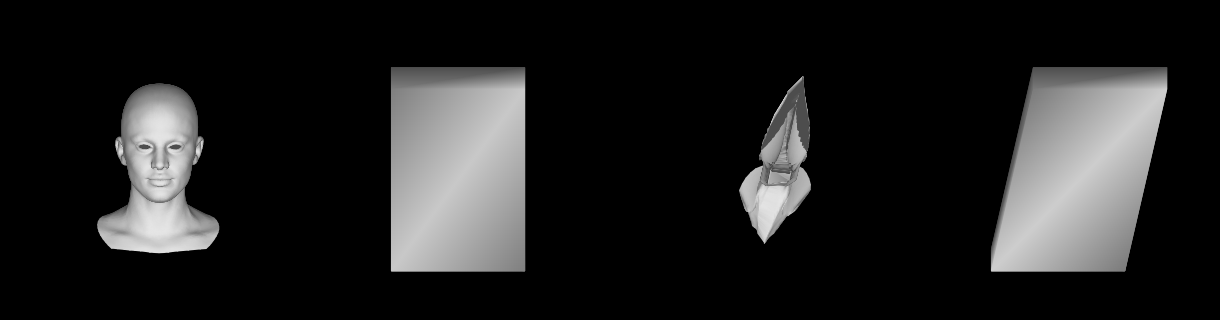

In [29]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        output[0],
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

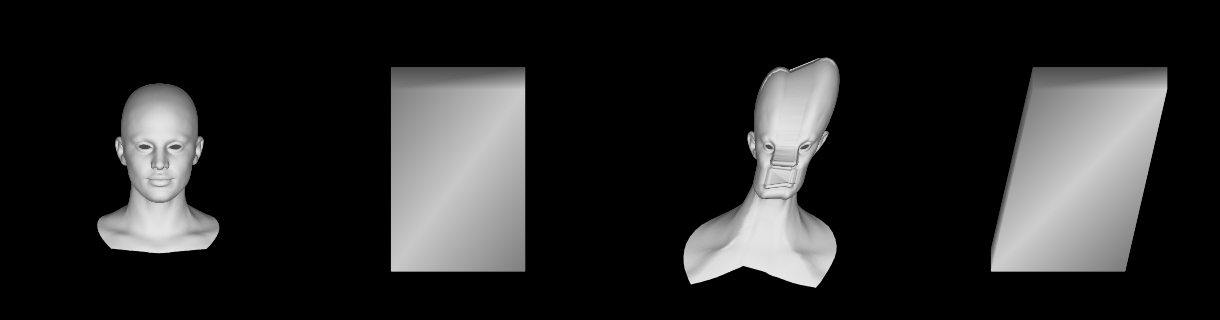

In [24]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        output,
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')